# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 28.03.2024

Мягкий дедлайн: 15.04.2024 23:59 MSK

Жёсткий дедлайн: 21.04.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). 

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning. 



In [2]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

/var/folders/28/21swhpms51l474n_ckq4ttcw90877k/T/ipykernel_2153/1945709582.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻

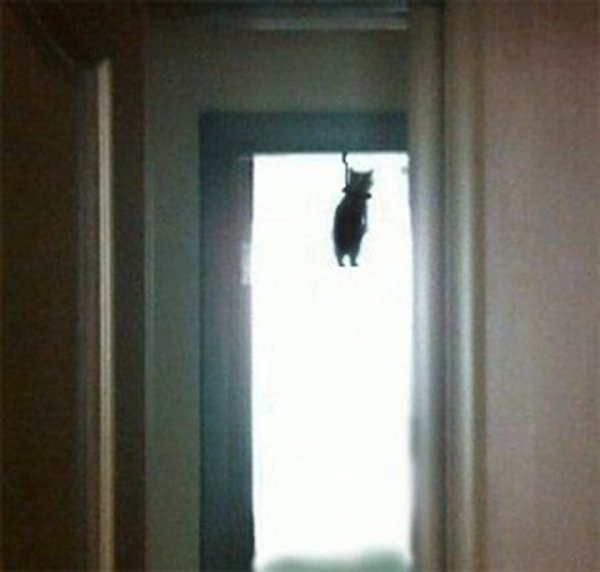

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [3]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans
from numpy import linalg


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''
        # n_samples - количество вершин
        # n_components - количество кластеров
        
        # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
        D = np.diag(np.sum(X, axis=1))
        L = D - X 
        eigenvalues, eigenvectors = linalg.eig(L) # достаем собственные значения и векторы из Лапласиана

        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        U = np.real(eigenvectors[:, :self.n_components])
        return U

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [4]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [5]:
data = pd.read_excel('transport.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

,index,ID_en,Name_en,Longitude_WGS84_en,Latitude_WGS84_en,Street_en,AdmArea_en,District_en,RouteNumbers_en,StationName_en,Direction_en,Pavilion_en,OperatingOrgName_en,EntryState_en,global_id,geoData
0,278,347,"«2-й Лесной пер.», улица Бутырский Вал (347)",37.586584,55.782106,улица Бутырский Вал,Czentral`ny'j administrativny'j okrug,Tverskoj rajon,АТ18; А12; АТ56; АТ78,2-й Лесной пер.,NaN,да,ГУП «Мосгортранс»,active,889085436,NaN
1,279,349,"«Ул. Сущевский Вал», Новослободская улица (349)",37.590714,55.790630,Новослободская улица,Czentral`ny'j administrativny'j okrug,Tverskoj rajon,АТ47; АМ10; АТ3; АТ56; АТ78,Ул. Сущевский Вал,NaN,да,ГУП «Мосгортранс»,active,889085437,NaN
2,355,479,"«Стадион Лужники (южн.) (пос.)», улица Лужники...",37.565972,55.714265,улица Лужники,Czentral`ny'j administrativny'j okrug,rajon Xamovniki,А64; А216; А809; АС12; А255; АБК; АТ79,Стадион Лужники (южн.) (пос.),NaN,да,ГУП «Мосгортранс»,active,889085549,NaN
3,356,480,"«Спортзал Дружба», Лужнецкая набережная (480)",37.570191,55.712504,Лужнецкая набережная,Czentral`ny'j administrativny'j okrug,rajon Xamovniki,А64; А216; А809; АС12; А255; АБК; АТ79,Спортзал Дружба,NaN,да,ГУП «Мосгортранс»,active,889085550,NaN
4,357,481,"«Лужнецкая наб.», Лужнецкая набережная (481)",37.574559,55.713770,Лужнецкая набережная,Czentral`ny'j administrativny'j okrug,rajon Xamovniki,А64; А216; А809; АС12; А255; АБК; АТ79,Лужнецкая наб.,NaN,да,ГУП «Мосгортранс»,active,889085551,NaN


Воспользуемся библиотекой `folium` для визуализации данных.

In [12]:
import folium

map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

ModuleNotFoundError: No module named 'folium'

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

Функция для подсчет расстояния между объектами

In [31]:
def haversine_route(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    #with ChatGPT help
   
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
   
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius = 6371  # Radius of the Earth in kilometers
    distance = radius * c

    return distance

In [29]:
from collections import defaultdict

def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    
    routes = defaultdict(list)

    for i in range(len(data)):
        # забираем все номера маршрутов на i-й остановке
        routes_numbers = data.iloc[i]['RouteNumbers_en'].split('; ')
        for route in routes_numbers:
            # пробегаемся по каждому маршруту
            # по ключу - названию маршрута - добавляем значение - ID остановки
            routes[route].append(data.iloc[i]['ID_en'])
    return dict(routes)


def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    
    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    
    sorted_routes = dict()
    
    for k, v in routes.items():
        # берем из датасета данные про все остановки на маршруте
        route_data = data.loc[data['ID_en'].isin(v)].copy()
        # считаем средние координаты по всем остановкам
        lon_mean = route_data['Longitude_WGS84_en'].mean()
        lat_mean = route_data['Latitude_WGS84_en'].mean()

        # считаем корректное расстояние с учетом формы Земли (haversine) от каждой остановки до средних координат
        route_data.loc[:, 'haversine'] = haversine_route(route_data['Latitude_WGS84_en'].values, route_data['Longitude_WGS84_en'].values,
                                                        lat_mean, lon_mean)
        # забираем расстояния
        haversine = route_data['haversine'].to_numpy()
        # сортируем по расстояниям
        idx = np.argsort(haversine)
        # берем ID самой отдаленной остановки от средних координат
        farthest_station = route_data.iloc[idx[-1]]['ID_en']
        # забираем координаты самой отдаленной остановки
        farthest_station_lat = route_data[route_data['ID_en'] == farthest_station]['Latitude_WGS84_en'].to_numpy()
        farthest_station_lng = route_data[route_data['ID_en'] == farthest_station]['Longitude_WGS84_en'].to_numpy()
        # создаем новую колонку: будет ставить 1 тем остановкам, которые мы забрали в отсортированный массив
        route_data['took_to_route'] = 0
        # создаем список с отсортированными остановками 
        # и помещаем туда самую дальнюю остановку в качестве первой
        sorted_stations = [farthest_station]
        # отмечаем, что мы взяли самую дальнюю остановку
        route_data.loc[route_data['ID_en'] == farthest_station, 'took_to_route'] += 1

        while route_data['took_to_route'].sum() < len(route_data):  # пока не отсортировали все остановки
            # забираем информацию про еще не отсортированные остановки
            route_data_dont_taken = route_data.loc[route_data['took_to_route'] != 1].copy()
            # считаем расстояние от каждой остановки до последней взятой (т.е. последней самой дальней)
            route_data_dont_taken.loc[:, 'haversine_to_farthest_station'] = haversine_route(route_data_dont_taken['Latitude_WGS84_en'].values, 
                                                                                            route_data_dont_taken['Longitude_WGS84_en'].values,
                                                                                            farthest_station_lat,
                                                                                            farthest_station_lng)
            # забираем расстояния, сортируем и выбираем самую ближайшую остановку к текущей
            haversine_to_farthest_station = route_data_dont_taken['haversine_to_farthest_station'].to_numpy()
            idx = np.argsort(haversine_to_farthest_station)
            next_station = route_data_dont_taken.iloc[idx]['ID_en'].to_numpy()[0]
            # добавляем саму самую ближайшую остановку к текущей в отсортированный массив
            sorted_stations.append(next_station)

            # отмечаем, что мы взяли новую остановку next_station в массив sorted_stations и забираем ее координаты для следующего сравнения
            route_data.loc[route_data['ID_en'] == next_station, 'took_to_route'] += 1
            farthest_station_lat = route_data[route_data['ID_en'] == next_station]['Latitude_WGS84_en'].to_numpy()
            farthest_station_lng = route_data[route_data['ID_en'] == next_station]['Longitude_WGS84_en'].to_numpy()

        # когда отсортировали все остановки, создаем новую пару ключ-значение в новом словаре
        sorted_routes[k] = sorted_stations

    return sorted_routes


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    
    # копируем массив, чтобы не изменять исходный
    data_copy = data.copy()
    # создаю фейковые метки, чтобы обращаться по ним к строкам и столбцам матрицы
    data_copy['_label'] = np.arange(len(data_copy))

    # инициализирую матрицу смежности нулями
    adjacency_matrix = np.zeros((data.shape[0],data.shape[0]))
    # пробегаюсь по строкам/стобцам, т.к. она симметричная
    for i in range(len(data)):
        # беру информацию про одну остановку
        station_data = data.iloc[i]
        # смотрю, какие маршруты проходят через нее
        routes_numbers = station_data['RouteNumbers_en'].split('; ')
        # пробегаюсь по маршрутам
        for route in routes_numbers:
            # беру остановки в отсортированном порядке
            stations_sorted = sorted_routes[route]
            if len(stations_sorted) < 2:
                # если на этом маршруте только 1 остановка, игнорируем, чтобы не было петель в графе
                continue
            
            for station_idx in range(len(stations_sorted)):
                # пробегаюсь по отсортированному маршруту
                if stations_sorted[station_idx - 1] == station_data['ID_en']:
                    # если предыдущая остановка - наша искомая, мы попали в соседнюю по этому маршруту, соединяем их ребром
                    # из предложенного алгоритма следует, что иначе попасть в эту остановку мы не можем
                    # берем информацию про станцию, с которой нужно соединить текущую
                    current_data = data_copy.loc[data_copy['ID_en'] == stations_sorted[station_idx]]
                    global_idx = int(current_data['_label'])
                    # попарно соединяем остановки ребром с весом, т.к. матрица симметричная
                    adjacency_matrix[i, global_idx] += 1
                    adjacency_matrix[global_idx, i] += 1
                    # поиск соседа по маршруту route завершен, круговых маршрутов у нас нет
                    break

    return adjacency_matrix

In [30]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

[55.78210613 55.79204084 55.79277781 55.79245674 55.78453867 55.78137611
 55.77440084 55.77348374 55.77214749 55.77024842 55.76683401 55.76364494
 55.75997455 55.75853807 55.75856154 55.75887887 55.76430509 55.76854718
 55.76995229 55.77213656 55.77301108 55.77388876 55.75725492 55.75717994
 55.75736514 55.79346767 55.76508824 55.79231649 55.77748815 55.77843184
 55.77708064 55.78563304 55.78862284 55.78961555 55.75690111 55.75885397
 55.7613826  55.76109619 55.76459951 55.76544216] [37.58658429 37.59640821 37.61745841 37.62353968 37.58689569 37.58602379
 37.58061178 37.57789054 37.57170017 37.56622358 37.5645397  37.56357478
 37.5606011  37.55213345 37.55400182 37.55919275 37.56418376 37.56541032
 37.56618862 37.57247339 37.57711704 37.57971434 37.54577858 37.53968549
 37.54513239 37.63492459 37.53786558 37.62719383 37.58492809 37.58514279
 37.58223268 37.58756943 37.58806958 37.58860038 37.54045679 37.53879784
 37.53979352 37.53931549 37.54066779 37.53993283] 55.77229174314711 37.571

/var/folders/28/21swhpms51l474n_ckq4ttcw90877k/T/ipykernel_2153/1167468757.py:128: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  global_idx = int(current_data['_label'])


Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [ ]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

In [ ]:
def draw_clustered_map(data, labels):
    '''
    Create map with coloured clusters
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with coloured clusters
    '''

    # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
    raise NotImplementedError

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:**

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [ ]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [ ]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [ ]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

In [ ]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:**

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

У какой модели получилось лучшее качество? С чем это связано?

**Ответ:**

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:**

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 6 (2 баллa)**. Спектральная кластеризация, по сути, является обычной кластеризацией KMeans поверх эмбеддингов объектов, которые получаются из лапласиана графа. А что, если мы попробуем построить эмбеддинги каким-нибудь другим способом? В этом задании мы предлагаем вам проявить немного фантазии. Возьмите какие-нибудь данные высокой размерности, чтобы задача обучения эмбеддингов имела смысл (например, картинки или тексты, желательно выбрать что-нибудь оригинальное). Придумайте или найдите какой-нибудь метод обучения эмбеддингов, примените его к данным и кластеризуйте полученные представления. Если чувствуете в себе достаточно силы, можете попробовать что-нибудь нейросетевое. Сравните ваш подход с базовыми алгоритмами кластеризации, которое мы рассмотрели в основном задании, не забывайте про визуализации! Ключевые слова для вдохновения: ***KernelPCA***, ***UMAP***, ***autoencoders***, ***gensim***. 

In [ ]:
# YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

**Задание 7 (1 балл)**. Наконец, ставший ежегодной традицией социализационный бонус. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за это задание, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

In [ ]:
# YOUR CODE HERE (ノಠ益ಠ)ノ彡┻━┻